In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../")
from dataset.dataset import *
from util.util import *
from model.model import *

---
<font size="5">Overviews</font>
1. Introduction
1. CelebA dataset
1. LCGAN
---

# Introduction

---
This notebook introduces LCGAN and it's colored with orange in diagram below.
Wheres the original conditional GAN employ the one-hot vector as a label, 
LCGAN employ a relational vector which is processed from the latent code of VAE.
Since the change from the original is just what to use as the label, 
the implementation is almost the same as usual.
Let's get started.

---

# Get CelebA dataset

In [5]:
label_discription = [
    "male, smiling, young",
    "male, smiling, old",
    "male, not_smiling, young",
    "male, not_smiling, old",
    "female, smiling, young",
    "female, smiling, old",
    "female, not_smiling, young",
    "female, not_smiling, old"
]

In [6]:
root = "./../../research/sound_dataset/celebA/img_align_celeba_png/"
label_root = "../../research/sound_dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
# dataset_label["delete"] = [11, 16, 36] 
dataset_label["class"] = [21, 32, 40] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
classes

(0, 1, 2, 3, 4, 5, 6, 7)

In [9]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
transform = {}
transform["train"] = transforms.Compose([
#     transforms.CenterCrop((178, 178)),
    transforms.CenterCrop((128, 128)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
    
transform["test"] = transforms.Compose([
#     transforms.CenterCrop((178, 178)),
    transforms.CenterCrop((128, 128)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [10]:
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=5000, val_num=0, test_num=100)

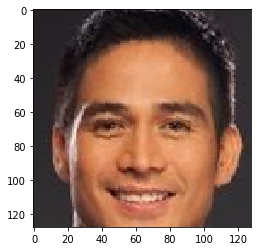

In [11]:
data = dataset[0]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
plt.imshow(image)

# LCGAN

## Preparation
I need to prepare the continuous label and some functions for training.

In [12]:
def label_standardization(data, mean=0, scale=1):
    m = np.mean(data, axis=0)
    s = np.std(data, axis=0)
    new_data = (data - m) / s
    new_data = (new_data + mean) * scale / np.sqrt(data.shape[1])
    return new_data

---
The label from the previous notebook is normalized to make it's mean and std be as follows:
$$
mean = 0 \\
std = \frac{1}{1.96\sqrt{dimension\_of\_the\_class}}
$$
---

In [13]:
# label_path = "../data/parameters/VAE_8classes_celebA_ndim512to3.pickle"
label_path = "../data/parameters/VAE_8classes_celebA_ndim128to3.pickle"
with open(label_path, 'rb') as f:
    relational_label = pickle.load(f)
relational_label = label_standardization(relational_label, scale=1/1.96)

In [14]:
trace = []
for lbl in range(len(classes)):
    m = relational_label[lbl]
    _x = m[0:1] 
    _y = m[1:2]
    _z = m[2:]
    trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"{label_discription[classes[lbl]]}", 
                              marker = dict(size=8)))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---


---

In [15]:
class GAN_training():
    def __init__(self, net, criterion, unrolled_k, classes, target_label, device):
        self.G, self.D = net[0].to(device), net[1].to(device)
        self.optG, self.optD = None, None
        self.scheG, self.scheD = None, None
        self.criterion = criterion
        self.k = unrolled_k
        self.classes = classes
        self.target_label = target_label
        self.device = device
        self.real_image_label = None
        self.fake_noise_label = None
        self.fake_label = None
        
    
    def opt_sche_initialization(self, lr=[0.0001, 0.0001]):
        lr_G, lr_D = lr
        self.optG = optim.Adam(self.G.parameters(), lr=lr_G, betas=(0.5, 0.999))
        self.scheG = optim.lr_scheduler.ExponentialLR(self.optG, gamma=0.99)
        self.optD = optim.Adam(self.D.parameters(), lr=lr_D, betas=(0.5, 0.999))
        self.scheD = optim.lr_scheduler.ExponentialLR(self.optD, gamma=0.99)
        return
    
    def get_loss_D(self, outputs, target=1.):
        loss = 0.0
        for output in outputs:
            targets = torch.full((output.shape), target, device=self.device)
            loss += criterion(output, targets)
        return loss / len(outputs)
    
    def concat_image_label(self, image, label, target_label=None):
        if type(target_label)!=np.ndarray:
            target_label = self.target_label
        B, C, H, W = image.shape
        label = torch.Tensor(target_label[label.cpu().numpy()]).to(self.device)
        image_label = label.view(-1, target_label.shape[1], 1, 1).expand(B, target_label.shape[1], H, W)
        return torch.cat((image, image_label), dim=1)
    
    def concat_noise_label(self, noise, label, target_label=None):
        if type(target_label)!=np.ndarray:
            target_label = self.target_label
        label = torch.Tensor(target_label[label.cpu().numpy()]).to(self.device)
        label = label.view(-1, target_label.shape[1], 1, 1)
        return torch.cat((noise, label), dim=1)
        
    def update_D(self):
        self.D.zero_grad()
        
        output = self.D(self.real_image_label)
        errD_real = self.get_loss_D(output, 1.)

        fake_image = self.G(self.fake_noise_label)
        fake_image_label = self.concat_image_label(fake_image, self.fake_label)
        output = self.D(fake_image_label.detach())
        errD_fake = self.get_loss_D(output, 0.)

        errD = errD_real + errD_fake
        
        errD.backward()
        self.optD.step()
        
        return errD
    
    def update_G(self):
        self.G.zero_grad()

        fake_image = self.G(self.fake_noise_label)
        fake_image_label = self.concat_image_label(fake_image, self.fake_label)
        
        output = self.D(fake_image_label)
        errG = self.get_loss_D(output, 1.)
        
        errG.backward()
        self.optG.step()
        
        return errG
    
    def UnrolledUpdate(self):
        for i in range(self.k):

            # update D
            errD = self.update_D()
            if i==0:
                paramD = self.D.state_dict()
                errorD = errD

        # update G
        errorG = self.update_G()
        self.D.load_state_dict(paramD)
        
        return [errorG, errorD]
        
        
    def train(self, real_image, real_label):
        self.real_image_label = self.concat_image_label(real_image, real_label)
        
        noise = torch.randn(real_image.shape[0], ndim, 1, 1, device=self.device)
        self.fake_label = torch.randint(len(self.classes), (real_image.shape[0],), dtype=torch.long, device=self.device)
        self.fake_noise_label = self.concat_noise_label(noise, self.fake_label)
        
        error = self.UnrolledUpdate()
        
        return error

---

---

In [40]:
epoch_num = 301
label_dim = relational_label.shape[1]
ndim = 1024
lr_D = 0.001
lr_G = 0.001
unrolled_k = 1
save_parameter = True
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [41]:
netG = Generator(ndim=ndim+label_dim, nch_output=3)
netG = netG.to(device)
netG.apply(weights_init)
netD = Discriminator(nch_input=3+label_dim, nch_output=1)
netD = netD.to(device)
netD.apply(weights_init)
criterion = nn.MSELoss()
gan = GAN_training([netG, netD], criterion, unrolled_k, classes, relational_label, device)
gan.opt_sche_initialization()

In [18]:
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=3000, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
len(dataset)

24000

## Training

In [19]:
fixed_noise = torch.randn(8, ndim, 1, 1, device=device)
fixed_noise_label = gan.concat_noise_label(fixed_noise, torch.tensor(np.arange(8)))

65


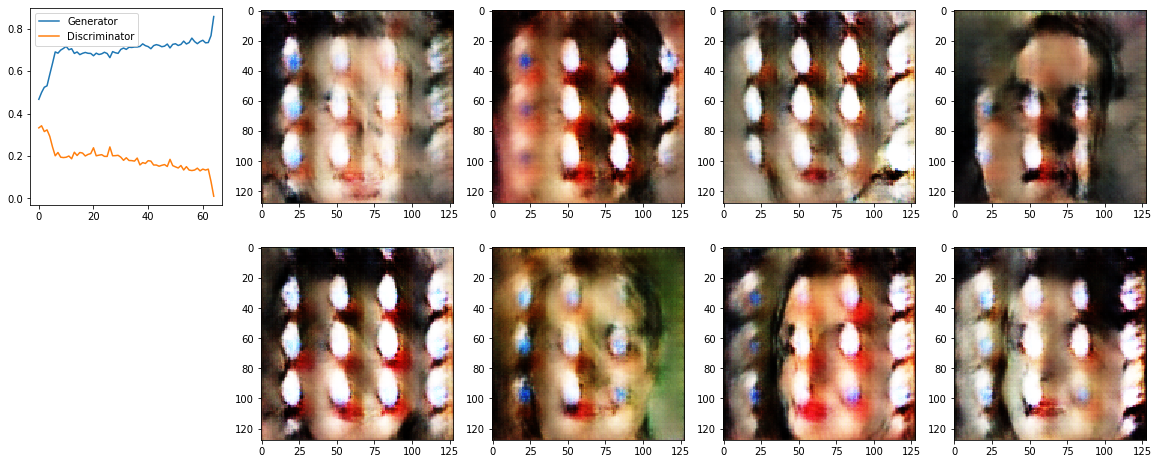

KeyboardInterrupt: 

In [20]:
losses_epoch_D = []
losses_epoch_G = []
for epoch in range(epoch_num):
    losses_G = []
    losses_D = []
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)
        real_label = data[1].to(device)
        
        errG, errD = gan.train(real_image, real_label)
        
        losses_G.append(cuda_to_numpy(errG))
        losses_D.append(cuda_to_numpy(errD))
        
    if save_parameter:
        if epoch % 10 == 0:
            torch.save(netG.state_dict(), 
                       f"./instant_model_parameter/lcgen_celebA_unrolled{unrolled_k}_ndim{ndim}_{label_dim}_epoch{epoch}.pth")
            torch.save(netD.state_dict(), 
                       f"./instant_model_parameter/lcdis_celebA_unrolled{unrolled_k}_ndim{ndim}_{label_dim}_epoch{epoch}.pth")
        
    losses_epoch_G.append(np.mean(np.array(losses_G)))
    losses_epoch_D.append(np.mean(np.array(losses_D)))
    
    gan.scheG.step()
    gan.scheD.step()
    
    sample_images = image_from_output(netG(fixed_noise_label))
    clear_output(wait=True)
    print(epoch+1)
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(2,5,1)
    ax.plot(losses_epoch_G, label="Generator")
    ax.plot(losses_epoch_D, label="Discriminator")
    ax.legend()
    for i in range(4):
        ax = fig.add_subplot(2,5,2+i)
        ax.imshow(sample_images[i])
    for i in range(4):
        ax = fig.add_subplot(2,5,7+i)
        ax.imshow(sample_images[4+i])
    plt.show()

## Results

In [42]:
epoch = 160
# epoch = 60
load_model = True
if load_model:
    gen_path = f"./instant_model_parameter/lcgen_celebA_unrolled{unrolled_k}_ndim{ndim}_{label_dim}_epoch{epoch}.pth"
    model_param = torch.load(gen_path, map_location=device)
    netG.load_state_dict(model_param)

### generate new image

In [43]:
label_discription =  [
    "male smiling young",
    "male smiling old",
    "male not_smiling young",
    "male not_smiling old",
    "female smiling young",
    "female smiling old",
    "female not_smiling young",
    "female not_smiling old"]

In [44]:
# center_label = np.zeros(center_label.shape)

In [45]:
generate_num = 32

In [46]:
class_num = 8

In [48]:
start = 24
seed_list = [0, 1, 3, 4]
seed_list = np.arange(start, start+4)

In [49]:
fake_label = torch.tensor([int(i) for i in range(class_num)] * (generate_num // class_num), dtype=torch.int64)
noise_g = torch.randn(1, ndim, 1, 1, device=device) 

In [50]:
np.random.seed(seed_list[0])
noise_g = np.repeat(np.random.randn(1, ndim, 1, 1), class_num, 0)
for i in range(generate_num // class_num - 1):
#     np.random.seed(i+28)
    np.random.seed(seed_list[i+1])
    a = np.repeat(np.random.randn(1, ndim, 1, 1), class_num, 0)
    noise_g = np.concatenate([noise_g, a], axis=0)
noise_g = torch.Tensor(noise_g).to(device)

In [51]:
fake_noise_label = gan.concat_noise_label(noise_g, fake_label)

In [52]:
netG.eval()
new_image = netG(fake_noise_label)
new_image = image_from_output(new_image)

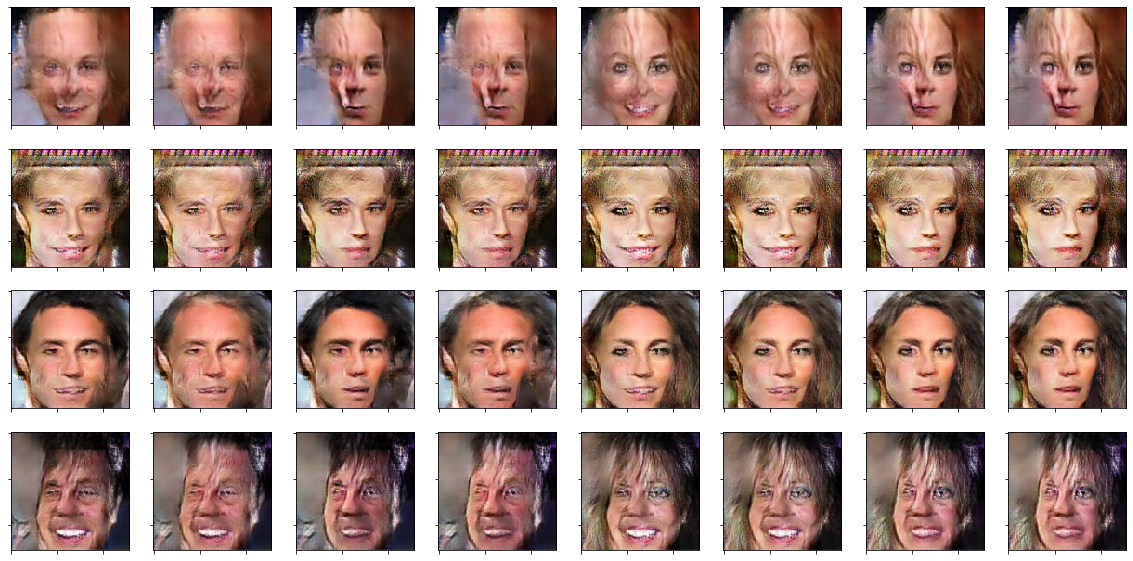

In [53]:
fig = plt.figure(figsize=(20, int(2.5*len(seed_list))), facecolor="w")
ax = []
for i in range(generate_num):
    ax = fig.add_subplot(generate_num//class_num, class_num, i+1)
    ax.imshow(new_image[i])
#     ax.set_title(f"{fake_label[i]}")
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

### moving label

In [202]:
each_tran = 11
delta = 1 / (each_tran-1)
delta

0.1

In [203]:
def get_moving_label(label, classes, delta=0.1):
    points = []
    for j in range(len(classes)-1):
        for i in range(int(1/delta)+1):
            alpha = delta * i
            point = (1-alpha)*label[classes[j]] + alpha*label[classes[j+1]]
            points.append(point)
    for i in range(int(1/delta)+1):
        alpha = delta * i
        point = (1-alpha)*label[classes[-1]] + alpha*label[classes[0]]
        points.append(point)
    points = np.array(points)
    return points

def get_moving_path(target_label, delta=0.1, route=np.array([])):
    if len(route)==0:
        route = two_opt(target_label, 0)
    moving_label = get_moving_label(target_label, route, delta)
    return moving_label, route

############### https://codeday.me/jp/qa/20190604/929507.html #######################################
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
    route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities.
    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.


In [204]:
moving_label, route = get_moving_path(relational_label, delta=delta)
moving_label.shape

(88, 3)

In [205]:
fig = go.Figure()
trace = []
for lbl in classes:
    m = relational_label[lbl]
    x_ = m[0:1] 
    y_ = m[1:2]
    z_ = m[2:]
    fig.add_trace(go.Scatter3d(x=x_, y=y_, z=z_, mode="markers", name=f"{lbl}", 
                              marker = dict(size=8)))
fig.update_layout(
    font = dict(       # グローバルのフォント設定
      family = '"Open Sans", verdana, arial, sans-serif',
      size = 12,
      color = '#444',
    ),
    title = dict(
      text = '',       # グラフのタイトル
      font = dict(),   # タイトルのフォント設定
    ),
    width = 500,       # 全体のサイズ
    height = 500,
    autosize = True,   # HTMLで表示したときページに合わせてリサイズするかどうか
    margin = dict(     # グラフ領域の余白設定
      l = 60, r = 60, t = 60, b = 60,
      pad = 0,         # グラフから軸のラベルまでのpadding
      autoexpand = True,  # LegendやSidebarが被ったときに自動で余白を増やすかどうか
    ),
    showlegend = True, # 凡例を表示するかどうか
    legend = go.layout.Legend(
      font = dict(size=25),   # 凡例のフォント設定
      x = 1.02, xanchor = 'left',  # 凡例の表示場所の設定
      y = 1, yanchor = 'auto',
      bordercolor = '#444', borderwidth = 0,  # 凡例を囲む枠線の設定
    ),
)
fig.update_layout(legend= {'itemsizing': 'constant'})
data = trace
iplot(fig)

In [206]:
fig = go.Figure()
trace = []
for i in range(len(classes)):
    x_ = moving_label[i*each_tran:(i+1)*each_tran, 0]
    y_ = moving_label[i*each_tran:(i+1)*each_tran, 1]
    z_ = moving_label[i*each_tran:(i+1)*each_tran, 2]
    fig.add_trace(go.Scatter3d(x=x_, y=y_, z=z_, mode="markers", name=f"{route[i]}to below", 
                              marker = dict(size=5)))
fig.update_layout(
    font = dict(       # グローバルのフォント設定
      family = '"Open Sans", verdana, arial, sans-serif',
      size = 12,
      color = '#444',
    ),
    title = dict(
      text = '',       # グラフのタイトル
      font = dict(),   # タイトルのフォント設定
    ),
    width = 600,       # 全体のサイズ
    height = 500,
    autosize = True,   # HTMLで表示したときページに合わせてリサイズするかどうか
    margin = dict(     # グラフ領域の余白設定
      l = 60, r = 60, t = 60, b = 60,
      pad = 0,         # グラフから軸のラベルまでのpadding
      autoexpand = True,  # LegendやSidebarが被ったときに自動で余白を増やすかどうか
    ),
    showlegend = True, # 凡例を表示するかどうか
    legend = go.layout.Legend(
      font = dict(size=18),   # 凡例のフォント設定
      x = 1.02, xanchor = 'left',  # 凡例の表示場所の設定
      y = 1, yanchor = 'auto',
      bordercolor = '#444', borderwidth = 0,  # 凡例を囲む枠線の設定
    ),
)
fig.update_layout(legend= {'itemsizing': 'constant'})
data = trace
iplot(fig)

In [207]:
generate_num = moving_label.shape[0]

In [208]:
fake_label = torch.tensor(range(generate_num), dtype=torch.int64)
noise_g = torch.randn(generate_num, ndim, 1, 1, device=device) 
np.random.seed(seed_list[1])
noise_g = torch.Tensor(np.repeat(np.random.randn(1, ndim, 1, 1), generate_num, 0)).to(device)

In [209]:
fake_noise_label = gan.concat_noise_label(noise_g, fake_label, moving_label)

In [210]:
fake_noise_label.shape

torch.Size([88, 1027, 1, 1])

In [211]:
netG.eval()
new_image = netG(fake_noise_label)

In [212]:
new_image_list = image_from_output(new_image)

In [213]:
from mpl_toolkits.mplot3d import Axes3D

In [214]:
len(new_image_list)

88

In [215]:
moving_label.shape

(88, 3)

In [225]:
import shutil

In [228]:
route

array([0, 1, 3, 2, 7, 6, 5, 4])

In [231]:
each = len(new_image_list) // len(classes)

In [236]:
each * (len(classes)-1)

77

In [248]:
"dfafsf \n dfasf"

'dfafsf \n dfasf'

In [241]:
label_discription[route[-1]]

'female smile young'

In [251]:
def save_gif(data_list, gif_path, relational_label, moving_label, route, save_dir = "contempolary_images/", fig_size=(16,8), font_title=24, duration=100, classes=tuple(range(8))):
    shutil.rmtree(save_dir, ignore_errors=True)
    os.makedirs(save_dir, exist_ok=True)
    each = len(data_list) // len(classes)
    for i in range(len(data_list)):
        fig = plt.figure(figsize=fig_size)
        plt.cla()
        ax = fig.add_subplot(1,2,1)
        ax.imshow(data_list[i])
        if i >= each * (len(classes)-1):
            ax.set_title(f"{label_discription[route[-1]]} \n to \n {label_discription[route[0]]}")
        else:
            ax.set_title(f"{label_discription[route[i//each]]} \n to \n {label_discription[route[i//each+1]]}")
            
        ax = fig.add_subplot(1,2,2, projection="3d")
        for lbl in classes:
            m = relational_label[lbl]
            x_ = m[0:1] 
            y_ = m[1:2]
            z_ = m[2:]
            ax.scatter3D(x_, y_, z_, label=f"{lbl}", s=40)
        a = moving_label[i:i+1,:]
        ax.scatter3D(a[:,0:1], a[:,1:2], a[:,2:3], label=f"current label", s=50)
        ax.view_init(elev=30., azim=210)
        ax.legend()
            
        save_path = save_dir + f"{str(i).zfill(3)}"
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.savefig(save_path, dpi = 64, facecolor = "lightgray", tight_layout=True)
        plt.close()
        
    files = sorted(glob.glob(save_dir + '*.png'))
    images = list(map(lambda file: Image.open(file), files))
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=duration, loop=0)

In [252]:
gif_path = "../data/gif/moving_label.gif"
save_gif(new_image_list, gif_path, relational_label, moving_label, route, duration=200)

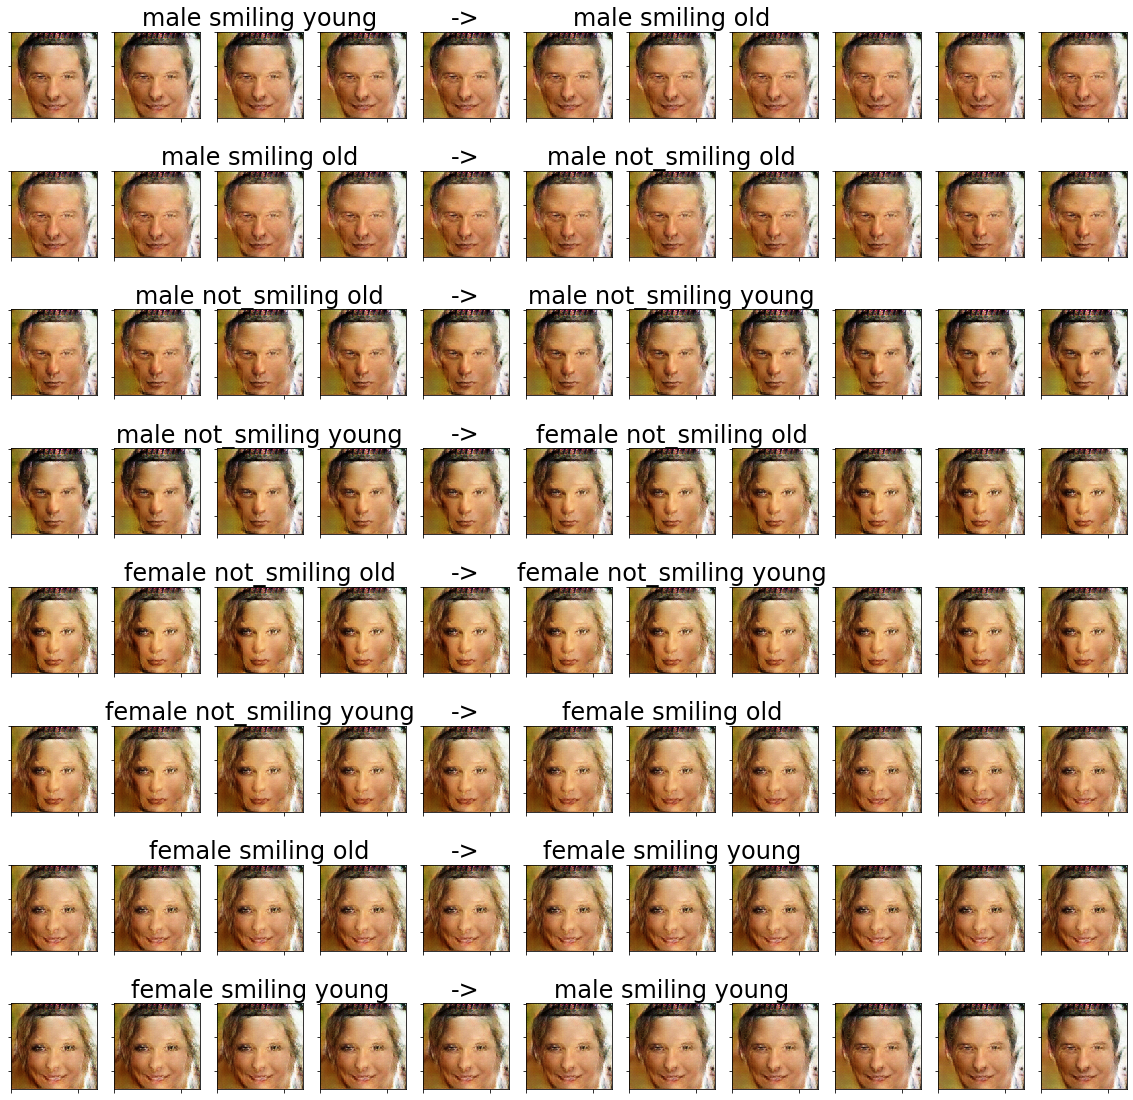

In [147]:
font_title = 24
fig = plt.figure(figsize=(20, 20), facecolor="w")
ax = []
for i in range(generate_num):
    ax.append(fig.add_subplot(len(classes), each_tran, i+1))
    ax[i].imshow(new_image_list[i])
    if i % each_tran == 2:
        ax[i].set_title(label_discription[route[i//each_tran]], fontsize=font_title)
    if i % each_tran == 4:
        ax[i].set_title("->", fontsize=font_title)
    if i % each_tran == 6:
        if i == each_tran*(len(classes)-1)+6:
            ax[i].set_title(label_discription[route[0]], fontsize=font_title)
        else:
            ax[i].set_title(label_discription[route[i//each_tran+1]], fontsize=font_title)
    ax[i].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

### moving label certain class

In [148]:
label_discription =  [
    "male smile young",
    "male smile old",
    "male not_smile young",
    "male not_smile old",
    "female smile young",
    "female smile old",
    "female not_smile young",
    "female not_smile old"]

In [149]:
selected = np.array([2, 7])

In [152]:
label_selected = relational_label[selected]

In [153]:
each_trans = 101
delta = 1 / (each_trans-1)
delta

0.01

In [154]:
moving_label, route = get_moving_path(label_selected, delta=delta)
moving_label = moving_label[:each_trans,:]
moving_label.shape

(101, 3)

In [157]:
trace = []
m = moving_label
x_ = m[:, 0] 
y_ = m[:, 1]
z_ = m[:, 2]
trace.append(go.Scatter3d(x=x_, y=y_, z=z_, mode="markers", name=f"{selected[0]} to {selected[1]}", 
                          marker = dict(size=5)))
for lbl in classes:
    m = relational_label[lbl]
    x_ = m[0:1] 
    y_ = m[1:2]
    z_ = m[2:]
    trace.append(go.Scatter3d(x=x_, y=y_, z=z_, mode="markers", name=f"{lbl}", 
                              marker = dict(size=5)))
layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

In [158]:
generate_num = moving_label.shape[0]

In [159]:
fake_label = torch.tensor(range(generate_num), dtype=torch.int64)
np.random.seed(seed_list[0])
noise_g = torch.randn(generate_num, ndim, 1, 1, device=device) 
np.random.seed(seed_list[0])
noise_g = torch.Tensor(np.repeat(np.random.randn(1, ndim, 1, 1), generate_num, 0)).to(device)

In [163]:
fake_noise_label = gan.concat_noise_label(noise_g, fake_label, moving_label)

In [165]:
netG.eval()
new_image = netG(fake_noise_label)

In [166]:
route

array([0, 1])

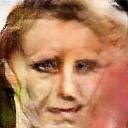

In [184]:
image_from_output(new_image)[]

TypeError: Invalid shape (3, 128, 128) for image data

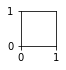

In [167]:
fig = plt.figure(figsize=(20, 10), facecolor="w")
ax = []
wide = 8
for i in range(generate_num):
    ax.append(fig.add_subplot(int(np.ceil(each_trans/wide)), wide, i+1))
    ax[i].imshow(np.squeeze(new_image[i].to("cpu").detach().numpy()))
#     if i % 11 == 4:
#         ax[i].set_title(label_discription[selected[route[i//11]]])
#     if i % 11 == 5:
#         ax[i].set_title("->")
#     if i % 11 == 6:
#         if i == 11*(len(selected)-1)+6:
#             ax[i].set_title(label_discription[selected[route[0]]])
#         else:
#             ax[i].set_title(label_discription[selected[route[i//11+1]]])
    ax[i].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

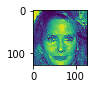

In [53]:
plt.figure(figsize=(5, 1))
plt.imshow(pic)
plt.show()

In [ ]:
font_title = 24
save = True
# for i in range(1):
save_dir = f"./pic/test/"
delete = save_dir + "*"
!rm $delete
for i in range(generate_num):
#     j = i % 11
    pic = np.squeeze(new_image[i].to("cpu").detach().numpy())
    plt.figure(figsize=(8, 8))
    plt.cla()
    plt.imshow(pic)
    plt.title(f"{each_trans-i} / {each_trans-1} * ({label_discription[selected[0]]})\n{i} / {each_trans-1} * ({label_discription[selected[1]]})", 
             fontsize=font_title)
    save_path = save_dir + f"{str(i).zfill(3)}"
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    if save:
        plt.savefig(save_path, dpi = 64, facecolor = "lightgray", tight_layout=True)

In [181]:
if save:
    files = sorted(glob.glob(save_dir + '*.png'))
    images = list(map(lambda file: Image.open(file), files))
    images[0].save(f'./pic/{save_dir.split("/")[-2]}.gif', save_all=True, append_images=images[1:], duration=50, loop=0)

#### save gif

In [56]:
label_discription =  [
    "male smiling young",
    "male smiling old",
    "male not_smiling young",
    "male not_smiling old",
    "female smiling young",
    "female smiling old",
    "female not_smiling young",
    "female not_smiling old"]

In [61]:
transition_list = [(0, 3), (1, 2), (4, 7), (5, 6), # gender
                   (0, 5), (1, 4), (2, 7), (3, 6), # smiling
                   (0, 6), (1, 7), (2, 4), (3, 5)] # age

In [62]:
selected_list = np.array([(0, 5), (2, 7), (5, 6), (0, 3), (1, 3)])
dir_list = ["center_smiling_smiling", "center_smiling_not", "center_gender_female", "center_gender_male", "center_face_selected"]

### trasintion between selected classes in each class

In [44]:
def get_transition_selected(selected, delta, label, seed=0):
    label_selected = label[selected]
    moving_label, route = get_moving_path(label_selected, delta=delta)
    generate_num = moving_label.shape[0]
    fake_label = torch.tensor(range(generate_num), dtype=torch.int64)
    noise_g = torch.randn(generate_num, ndim, 1, 1, device=device) 
    np.random.seed(seed)
    a = np.random.randn(1, ndim, 1, 1)
    noise_g = torch.Tensor(np.repeat(a, generate_num, 0)).to(device)
    fake_noise_label = concat_noise_label(noise_g, fake_label, device, label_dim, moving_label)[:11]
    netG.eval()
    new_image = netG(fake_noise_label)
    return new_image

In [45]:
label_discription =  [
    "male smiling young",
    "male smiling old",
    "male not_smiling young",
    "male not_smiling old",
    "female smiling young",
    "female smiling old",
    "female not_smiling young",
    "female not_smiling old"]

In [120]:
transition_list = [(0, 3), (1, 2), (4, 7), (5, 6), # gender
                   (0, 5), (1, 4), (2, 7), (3, 6), # smiling
                   (0, 6), (1, 7), (2, 4), (3, 5)] # age

In [48]:
each_tran = 9
delta = 1 / (each_tran-1)
npt = int(1/delta) + 1

In [ ]:
ax = []
font_title = 24
for j in range(len(transition_list)):
    selected = list(transition_list[j])
    new_image = get_transition_selected(selected, delta, center_label, seed_list[0])
    fig = plt.figure(figsize=(20, 4), facecolor="w")
    for i in range(npt):
        ax = fig.add_subplot(1, npt, i+1)
        ax.imshow(np.squeeze(new_image[i].to("cpu").detach().numpy()))
        if i % npt == 2:
            ax.set_title(f"{label_discription[selected[0]]}", fontsize=font_title)
        if i % npt == 4:
            ax.set_title("->", fontsize=font_title)
        if i % npt == 6:
            ax.set_title(f"{label_discription[selected[1]]}", fontsize=font_title)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

In [52]:
transition_list = [(0, 3), (1, 2), (4, 7), (5, 6), # gender
                   (0, 5), (1, 4), (2, 7), (3, 6), # smiling
                   (0, 6), (1, 7), (2, 4), (3, 5)] # age
transition_list = [(0, 3), (1, 2), (4, 7), (5, 6)] # gender
# transition_list = [(0, 5), (1, 4), (2, 7), (3, 6)] # smiling
transition_list = [(0, 5), (2, 7)] # smiling
# transition_list = [(0, 6), (1, 7), (2, 4), (3, 5)] # age

In [ ]:
ax = []
font_title = 24
fig = plt.figure(figsize=(20, 5), facecolor="w")
for j in range(len(transition_list)):
    selected = list(transition_list[j])
    new_image = get_transition_selected(selected, delta, center_label, seed_list[0])
    for i in range(npt):
        ax = fig.add_subplot(len(transition_list), npt, j*npt+i+1)
        ax.imshow(np.squeeze(new_image[i].to("cpu").detach().numpy()))
        if i % npt == 2:
            ax.set_title(f"{label_discription[selected[0]]}", fontsize=font_title)
        if i % npt == 4:
            ax.set_title("->", fontsize=font_title)
        if i % npt == 6:
            ax.set_title(f"{label_discription[selected[1]]}", fontsize=font_title)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)